<a href="https://colab.research.google.com/github/s017274/RedliningExploration/blob/main/Redlining_in_Philadelphia_(GeoJSON).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Python geospatial analysis of redlining**

Datasets: 
* Philadelphia redlining data from the Richmond DSL project Mapping Inequality: https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58&text=downloads
* Philadelphia crime data (2021): https://www.opendataphilly.org/dataset/crime-incidents 

##Set-up

In [1]:
#This installs the necessary dependencies
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.1 MB/s 
     |████████████████████████████████| 6.3 MB 22.9 MB/s 
     |████████████████████████████████| 15.4 MB 21.9 MB/s 


In [13]:
#Imports
import geopandas as gdp
import matplotlib as plt
import pandas as pd
import numpy as np
import math

In [5]:
#Reads in file
redlining_data = gdp.read_file('/content/PAPhiladelphia1937.geojson')
philly_crime_data = pd.read_csv('/content/incidents_part1_part2.csv')
#Prints categories in file
print(redlining_data.columns)
print(philly_crime_data.columns)

Index(['name', 'holc_id', 'holc_grade', 'area_description_data', 'geometry'], dtype='object')
Index(['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist',
       'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour_',
       'dc_key', 'location_block', 'ucr_general', 'text_general_code',
       'point_x', 'point_y', 'lat', 'lng'],
      dtype='object')


In [4]:
philly_crime_data.head()

,the_geom,cartodb_id,the_geom_webmercator,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
0,0101000020E6100000ECBC5322C5CE52C03D31678D2CF1...,2640566,0101000020110F00003952D0165FF25FC17988322F797F...,5084575,12,1,2021-03-19 10:41:04,2021-03-19,10:41:04,10.0,202112018994,4500 BLOCK ISLAND AV,600,Thefts,-75.230782,39.884172,39.884172,-75.230782
1,0101000020E61000007A37B3E9CAC652C05C69211AC003...,2640573,0101000020110F00003952C02BD2E45FC128F33D3F0E94...,4627971,15,1,2021-02-25 16:44:00,2021-02-25,16:44:00,16.0,202115013539,E ROOSEVELT BLVD / WHITAKER AV,700,Motor Vehicle Theft,-75.106135,40.029300,40.029300,-75.106135
2,0101000020E6100000C9F4955136C752C0DCD4A31DF5FE...,2640955,0101000020110F000060AD479C88E55FC1780A94B2BD8E...,5221029,24,2,2021-03-25 22:33:54,2021-03-25,22:33:54,22.0,202124019454,3100 BLOCK FRANKFORD AV,1500,Weapon Violations,-75.112690,39.991855,39.991855,-75.112690
3,0101000020E6100000684F76F106C952C0CA7097587406...,2640957,0101000020110F00004A556CD29DE85FC12E37B02C0E97...,3500576,35,1,2021-01-02 18:57:00,2021-01-02,18:57:00,18.0,202135000451,N PARK AV / CHELTEN AV,700,Motor Vehicle Theft,-75.141049,40.050426,40.050426,-75.141049
4,0101000020E6100000A21CD49748CF52C0223A3E398EFB...,2641121,0101000020110F00003528AC623EF35FC163C50F75F88A...,4993349,19,2,2021-03-16 00:07:48,2021-03-16,00:07:48,0.0,202119014625,5900 BLOCK SPRING ST,1400,Vandalism/Criminal Mischief,NaN,NaN,39.965278,-75.238806


##Analyzing crime rates in different HOLC grades

In [ ]:
# Areas with most crimes committed

philly_crime_data = philly_crime_data.iloc[:1000]
areas = philly_crime_data['location_block']
crimes = philly_crime_data['text_general_code']

crimes_per_area = [("",0)]
for i in range(len(areas)):
  crimes_per_area.append((areas[i], crimes[i]))

areas = list(set(areas))

final_list = {"": []}

for area in areas:
  for item in crimes_per_area:
    final_list[area] = []
    if item[0] == area:
      final_list[area].append(item[1])

for item in final_list:
  if item == "" or pd.isnull(item):
    print("Invalid")
  else:
    # print(len(item[1]))
    max = 0
    max_crime = ""
    for crime in item[1]:
      if item[1].count(crime) > max:
        max = item[1].count(crime)
        max_crime = crime
    print(str(max_crime) + ":" + str(max))



##Identifying HOLC grades where minority groups were noted

* Black, Jewish, and Italian populations were considered a negative factor in investment security.

In [24]:
data_dict = {}

ids = redlining_data['holc_id']
grades = redlining_data['holc_grade']
descriptions = redlining_data['area_description_data']

for i in range(82):
  array = [ids[i], grades[i], descriptions[i]]
  data_dict[i] = array



This block of code shows that the average HOLC grade for an area where the report dictated that Black residents lived was 'C', the second lowest grade - 'Definitely Declining' - while those areas without any noted Black population averaged 'A' - desirable.

In [25]:
# Creates variables for storing grades and names of areas
yes_5d = []
yes_5d_areas = []

no_5d = []
no_5d_areas = []

# Loops through dictionary (which has grades, IDs, and descriptions)
for value in data_dict.values():
  if (not value[2] == {"":""}):
    answer = value[2]["5d"]
    if 'nominal' in answer or 'yes' in answer or 'Yes' in answer or 'Threatening' in answer:
      yes_5d.append(value[1])
      yes_5d_areas.append(value[2]['1'])
    else:
      no_5d.append(value[1])
      no_5d_areas.append(value[2]['1'])

average_yes = 0.0
average_no = 0.0

# Adds up the ASCII values of grades - A, B, C, or D = 65, 66, 67, or 68
for i in range(len(yes_5d)):
  average_yes += ord(yes_5d[i])
  average_no += ord(no_5d[i])

# Gets the average ASCII value
average_yes = average_yes/len(yes_5d)
average_no = average_no/len(yes_5d)

# Converts the rounded ASCII value back into a letter grade and outputs it
print("Average Grade of Area with Black Population: " + chr(int(average_yes)))
print("Average Grade of Area with No Black Population: " + chr(int(average_no)))

Average Grade of Area with Black Population: C
Average Grade of Area with No Black Population: A


List of area descriptions

In [41]:
area_descriptions = {0:''}
index = 0
for item in redlining_data['area_description_data']:
  area_descriptions[index] = item
  index += 1

Searches for keywords (racial and ethnic minority groups that were discriminated against)

In [27]:
keywords_found = []
keywords = ['negro', 'jewish', 'italian', 'negroes']
for item in area_descriptions.items():
  if not (item[1] == {'': ''}): 
    string1 = item[1]['4']
    string2 = item[1]['14']
    for word in keywords:
      if word in string1 or word in string2:
        keywords_found.append(item[1]['1'])

print(keywords_found)

['Philadelphia B 5', 'Sub. Holmesburg C 11', 'Philadelphia C 14', 'PHILADELPHIA D 11', 'Philadelphia D 14', 'Philadelphia D 15', 'South Philadelphia D 18', 'South Philadelphia D 18', 'Philadelphia D 21', 'Philadelphia D 21', 'Philadelphia D 22', 'Philadelphia D 23', 'Philadelphia, Pa. D 6']


Looks for the HOLC grades that were assigned to areas recorded to have the ethnic/racial minority groups

In [40]:
ids_and_race = {'':''}

holc_grades = redlining_data['holc_id']
descriptions = redlining_data['area_description_data']

for item in descriptions:
  if not(item == {'':''}):
    for word in keywords_found:
      if item['1'] == word and "Philadelphia" in item['1'] and not "Sub" in item['1'] :
        ids_and_race[word] = item['1'][13]

print("The HOLC grades for areas described as having high amounts of minority residents: ")
print(ids_and_race.values())

The HOLC grades for areas described as having high amounts of minority residents: 
dict_values(['', 'B', 'C', 'D', 'D', 'l', 'D', 'D', 'D', ' '])


##Visualizing HOLC grades

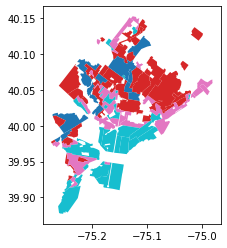

In [ ]:
redlining_data.plot(column = "holc_grade")

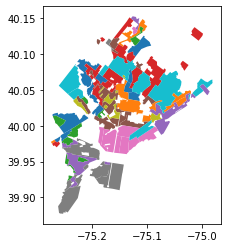

In [ ]:
redlining_data.plot(column = "holc_id")